# Stroke Prediction

## <b> <font color=green>Problem Definition, Scoping & Framing </font> </b>

#### Problem Statement
- Develop a machine learning model to predict stroke risk in patients based on clinical and demographic factors

- Early identification of high-risk patients for preventive intervention

- Create a reliable, interpretable prediction system that healthcare providers can trust and use

----

- Task Type: Binary Classification

- Target Variable: Stroke occurrence (0 = No stroke, 1 = Stroke)

- Input Features: Patient demographics, medical history, lifestyle factors

### 1.1) Load Libraries
Import all necessary libraries for the project.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn import svm 
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### 1.2) Load The Dataset
Load the dataset and display the first few rows.

In [3]:
DF = pd.read_csv('healthcare-dataset-stroke-data.csv')
DF.head(10)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


## <b> <font color=green> Exploration & Understanding </font> </b>

### 2.1) Descriptive Statistics
Generate summary statistics for the dataset.

In [4]:
DF.shape

(5110, 12)

In [5]:
DF.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [6]:
DF.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### 2.2) Data Visualizations
Visualize the data to identify patterns and relationships.

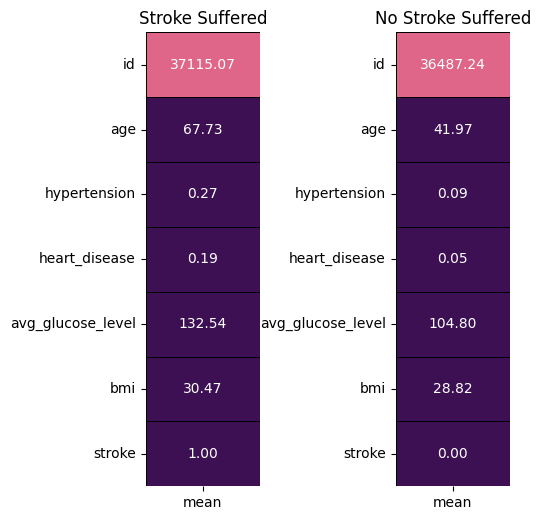

In [7]:
stroke = DF[DF['stroke'] == 1].describe().T
no_stroke = DF[DF['stroke'] == 0].describe().T

colors = ['#3C1053','#DF6589']

fig,ax = plt.subplots(nrows = 1,ncols = 2,figsize = (5,5))
plt.subplot(1,2,1)
sns.heatmap(stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('Stroke Suffered')

plt.subplot(1,2,2)
sns.heatmap(no_stroke[['mean']],annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black',cbar = False,fmt = '.2f')
plt.title('No Stroke Suffered')

fig.tight_layout(pad = 0)


* Mean values of all the features for cases of stroke suffered and no stroke suffered.

* age and avg_glucose_level can be solid 1st hand indicators to identify a stroke.
* Mean age values of patients that suffered a stroke, 67.73,is much higher than those did not suffer a stroke, 41.97.
* Similarly, avg_glucose_level value of 132.54 can indicate a higher chance of suffering from stroke than the avg_glucose_level value of 104.80 that has been found in patients that did not suffer a stroke

## <b> <font color=green> Data Preparation & Feature Engineering </font> </b>

### 3.1) Data Cleaning
Handle missing values and outliers.

In [8]:
DF.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

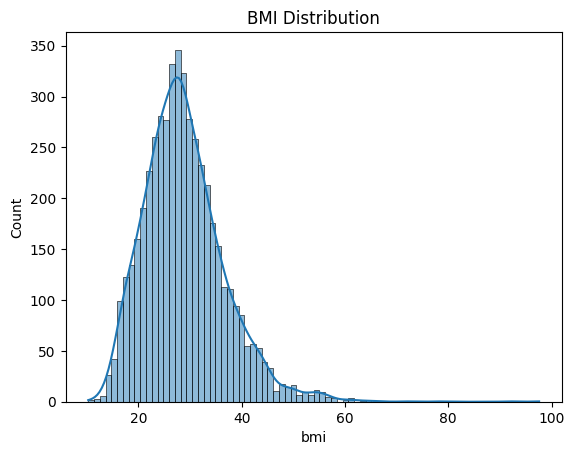

In [9]:
sns.histplot(DF['bmi'], kde=True)
plt.title('BMI Distribution')
plt.show()

In [10]:
DF['bmi'].fillna(DF['bmi'].mean(), inplace=True)

In [11]:
DF.drop(columns = ['id'],inplace = True)
col = list(DF.columns)
categorical_features = []
discrete_features = []
for i in col:
    if len(DF[i].unique()) > 6:
        discrete_features.append(i)
    else:
        categorical_features.append(i)

print('Categorical Features :',*categorical_features)
print('Discrete Features :',*discrete_features)

DF['age'] = DF['age'].astype(int)
df1 = DF.copy(deep = True)

Categorical Features : gender hypertension heart_disease ever_married work_type Residence_type smoking_status stroke
Discrete Features : age avg_glucose_level bmi


* We drop the id column as it is just a unique identifier.

* Here, categorical features are defined if the the attribute has less than 6 unique elements else it is a discrete feature.

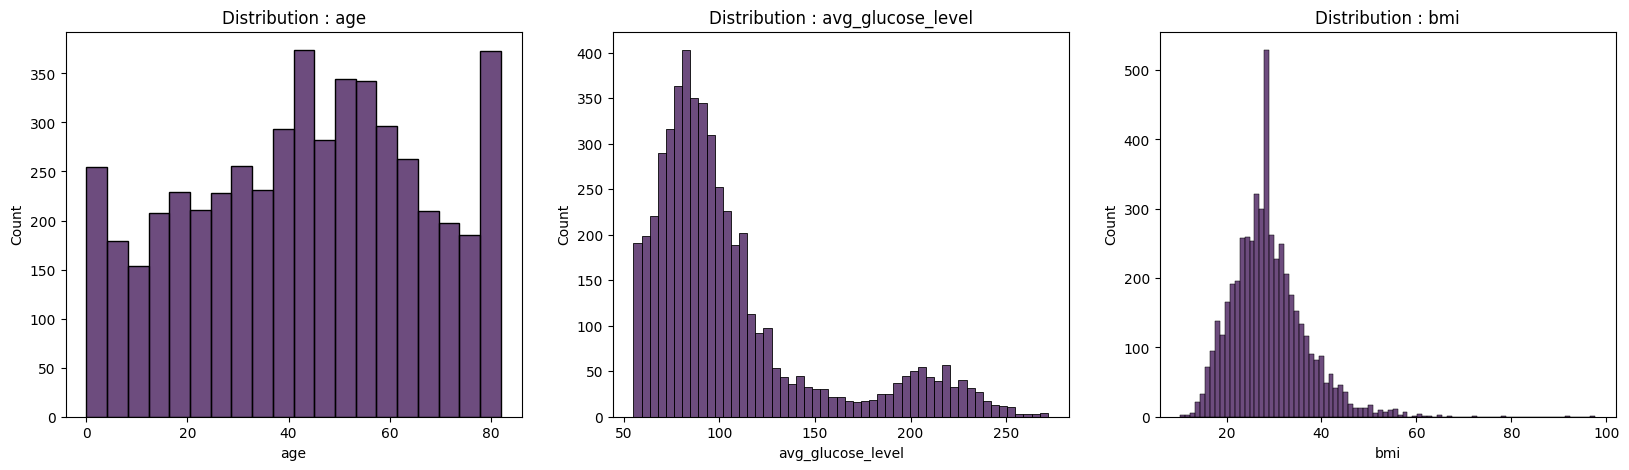

In [12]:
fig, ax = plt.subplots(nrows = 1,ncols = 3,figsize = (20,5))
for i in range(len(discrete_features)):
    plt.subplot(1,3,i+1)
    sns.histplot(df1[discrete_features[i]],color = colors[0])
    title = 'Distribution : ' + discrete_features[i]
    plt.title(title)
plt.show()

### 3.1) Data Transforms - Encoding
Apply transformations to prepare the data for modeling.

In [13]:
from sklearn.preprocessing import LabelEncoder

text_data_features = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

encoders = {}

print("Label Encoder Transformation:")
for col in text_data_features:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    encoders[col] = le 
    print(f"{col} : {dict(zip(le.classes_, le.transform(le.classes_)))}")


Label Encoder Transformation:
gender : {'Female': np.int64(0), 'Male': np.int64(1), 'Other': np.int64(2)}
ever_married : {'No': np.int64(0), 'Yes': np.int64(1)}
work_type : {'Govt_job': np.int64(0), 'Never_worked': np.int64(1), 'Private': np.int64(2), 'Self-employed': np.int64(3), 'children': np.int64(4)}
Residence_type : {'Rural': np.int64(0), 'Urban': np.int64(1)}
smoking_status : {'Unknown': np.int64(0), 'formerly smoked': np.int64(1), 'never smoked': np.int64(2), 'smokes': np.int64(3)}


* gender  :  [1 0 2]  =  ['Male' 'Female' 'Other']
* ever_married  :  [1 0]  =  ['Yes' 'No']
* work_type  :  [2 3 0 4 1]  =  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
* Residence_type  :  [1 0]  =  ['Urban' 'Rural']
* smoking_status  :  [1 2 3 0]  =  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']

In [14]:
tf1 = {}

for col, le in encoders.items():
    tf1[col] = dict(zip(le.transform(le.classes_), le.classes_))

tf1['hypertension'] = {0: 'No Hypertension', 1: 'Hypertension'}
tf1['heart_disease'] = {0: 'No Heart Disease', 1: 'Heart Disease'}

tf1


{'gender': {np.int64(0): 'Female', np.int64(1): 'Male', np.int64(2): 'Other'},
 'ever_married': {np.int64(0): 'No', np.int64(1): 'Yes'},
 'work_type': {np.int64(0): 'Govt_job',
  np.int64(1): 'Never_worked',
  np.int64(2): 'Private',
  np.int64(3): 'Self-employed',
  np.int64(4): 'children'},
 'Residence_type': {np.int64(0): 'Rural', np.int64(1): 'Urban'},
 'smoking_status': {np.int64(0): 'Unknown',
  np.int64(1): 'formerly smoked',
  np.int64(2): 'never smoked',
  np.int64(3): 'smokes'},
 'hypertension': {0: 'No Hypertension', 1: 'Hypertension'},
 'heart_disease': {0: 'No Heart Disease', 1: 'Heart Disease'}}

<Axes: xlabel='stroke', ylabel='count'>

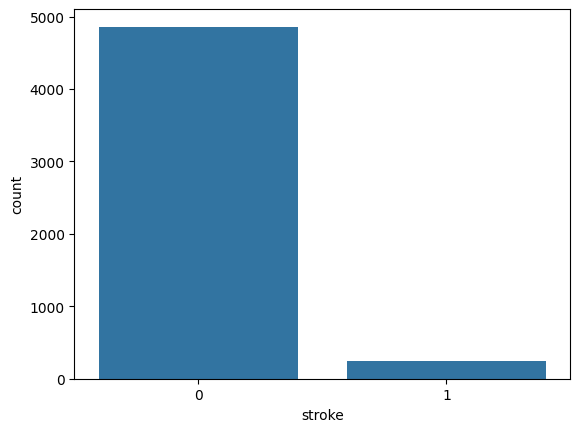

In [15]:
sns.countplot(DF,x='stroke')

The dataset is Unbalanced with a bias towards No Stroke.

In [16]:
X = df1.drop(['stroke'], axis = 1)
y = df1['stroke']

X_train, X_test, y_train , y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
X_train.shape, X_test.shape


((3423, 10), (1687, 10))

In [17]:
clf_gini = DecisionTreeClassifier(criterion='gini', random_state=42,max_depth= 5)
clf_gini.fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)

print(confusion_matrix(y_test, y_pred_gini))
print(classification_report(y_test, y_pred_gini))

[[1578   13]
 [  92    4]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1591
           1       0.24      0.04      0.07        96

    accuracy                           0.94      1687
   macro avg       0.59      0.52      0.52      1687
weighted avg       0.90      0.94      0.92      1687



The model is predicting almost all samples as no stroke → easy high accuracy because class 0 dominates!!

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

#UnderSampling:
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X, y)
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42)


In [45]:
#Applying DT Model in UnderSampling:
clf_gini_under = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=5)
clf_gini_under.fit(X_train_under, y_train_under)
y_pred_gini_under = clf_gini_under.predict(X_test_under)

#Evaluate the model:
print("UNDERSAMPLED:")
print(confusion_matrix(y_test_under, y_pred_gini_under))
print(classification_report(y_test_under, y_pred_gini_under))


UNDERSAMPLED:
[[37 14]
 [20 29]]
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        51
           1       0.67      0.59      0.63        49

    accuracy                           0.66       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.66      0.66      0.66       100



In [20]:
#OverSampling:
smote = SMOTE(random_state=42)
X_over, y_over = smote.fit_resample(X, y)
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over, y_over, test_size=0.2, random_state=42)

In [46]:
#Applying DT Model in OverSampling:
clf_gini_over = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=5)
clf_gini_over.fit(X_train_over, y_train_over)
y_pred_gini_over = clf_gini_over.predict(X_test_over)

#Evaluate the model:
print("OVERSAMPLED:")
print(confusion_matrix(y_test_over, y_pred_gini_over))
print(classification_report(y_test_over, y_pred_gini_over))

OVERSAMPLED:
[[718 257]
 [101 869]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       975
           1       0.77      0.90      0.83       970

    accuracy                           0.82      1945
   macro avg       0.82      0.82      0.81      1945
weighted avg       0.82      0.82      0.81      1945



#### Undersampling:

* Accuracy **66%**

* Recall = **0.59**

But small data, so overall weaker metrics and possible instability.

#### Oversampling (SMOTE):

* Accuracy jumps to **82%**

* Recall for stroke (class 1) = **0.90**

Balanced precision & f1 — so the model learns both classes properly.

### 3.2) Feature Selection
Select the most relevant features for the model.

In [22]:
importances = clf_gini_over.feature_importances_
feature_names = X_train_over.columns

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp)

age                  0.764986
work_type            0.068007
avg_glucose_level    0.044925
gender               0.030543
bmi                  0.022463
smoking_status       0.018783
hypertension         0.016657
Residence_type       0.014795
heart_disease        0.010479
ever_married         0.008362
dtype: float64


Top selected features: ['age', 'work_type', 'avg_glucose_level', 'gender', 'bmi', 'smoking_status', 'hypertension', 'Residence_type', 'heart_disease', 'ever_married']


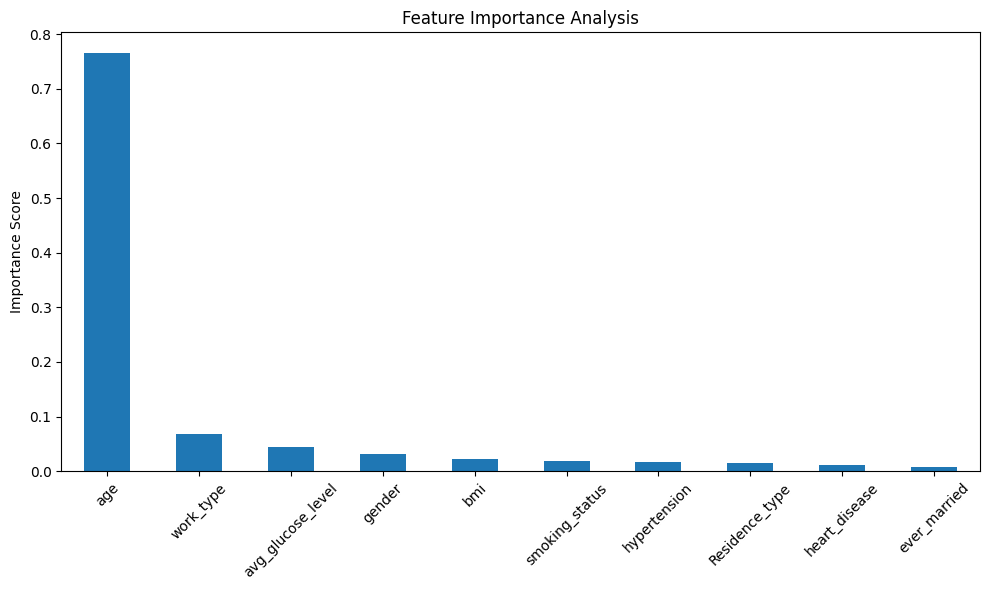

In [23]:
top_features = feat_imp.head(10).index.tolist()
print("Top selected features:", top_features)
plt.figure(figsize=(10, 6))
feat_imp.plot(kind='bar')
plt.title('Feature Importance Analysis')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
X_train_selected = X_train_over[top_features]
X_test_selected = X_test_over[top_features]


In [26]:
clf_gini_selected = DecisionTreeClassifier(criterion='gini', random_state=0, max_depth=5)
clf_gini_selected.fit(X_train_selected, y_train_over)

y_pred_selected = clf_gini_selected.predict(X_test_selected)

# Evaluate
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test_over, y_pred_selected))
print(classification_report(y_test_over, y_pred_selected))


[[718 257]
 [101 869]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.80       975
           1       0.77      0.90      0.83       970

    accuracy                           0.82      1945
   macro avg       0.82      0.82      0.81      1945
weighted avg       0.82      0.82      0.81      1945



True 0 predicted as 0: 718

True 0 predicted as 1: 257 - FP

True 1 predicted as 1: 869

True 1 predicted as 0: 101 - FN

--
* Class 0 (no stroke)
Precision: 0.88
Recall: 0.74

* Class 1 (stroke):
Precision: 0.77
Recall: 0.90

Accuracy: 0.82

## <b> <font color=green>  ML Model Selection & Evaluation </font> </b>

#### Logistic Regression

In [27]:
model = LogisticRegression()
model.fit(X_train_selected,y_train_over)
prediction3=model.predict(X_test_selected)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_test_over,prediction3))

The accuracy of the Logistic Regression is 0.8061696658097687


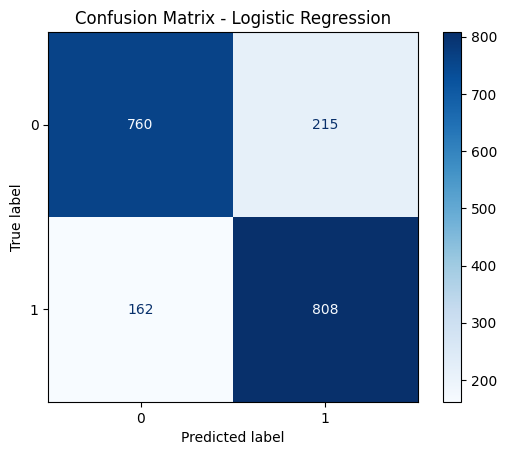

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_over, prediction3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


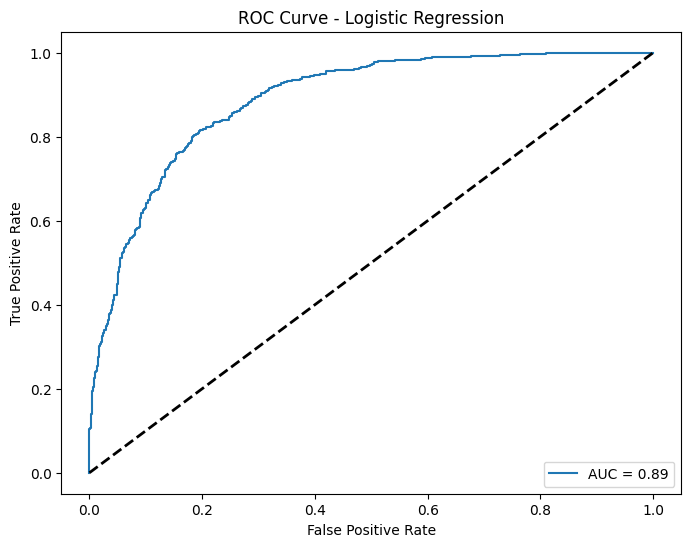

In [29]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc

y_proba = model.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_over, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()


#### Decision Tree

In [30]:
model=DecisionTreeClassifier()
model.fit(X_train_selected,y_train_over)
prediction4=model.predict(X_test_selected)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(y_test_over,prediction4))

The accuracy of the Decision Tree is 0.9095115681233933


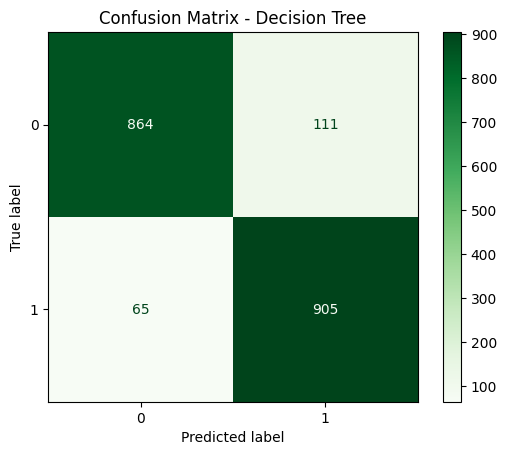

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_over, prediction4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Greens')
plt.title('Confusion Matrix - Decision Tree')
plt.show()


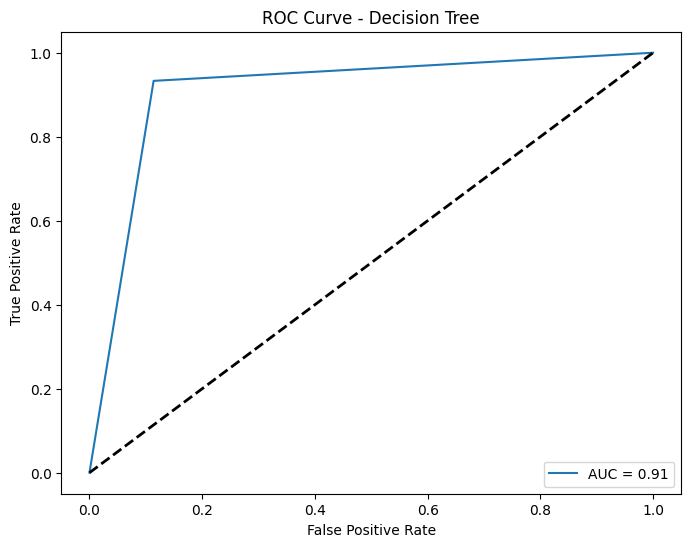

In [32]:
from sklearn.metrics import roc_curve, auc

# For Decision Tree, use predict_proba
y_proba = model.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_over, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.show()


#### K neighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

model = KNeighborsClassifier()
model.fit(X_train_selected, y_train_over)
prediction5 = model.predict(X_test_selected)

print('The accuracy of the KNN is', metrics.accuracy_score(y_test_over, prediction5))


The accuracy of the KNN is 0.8894601542416453


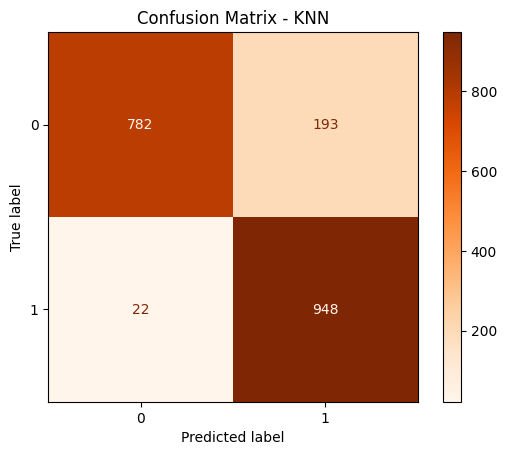

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_over, prediction5)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Oranges')
plt.title('Confusion Matrix - KNN')
plt.show()


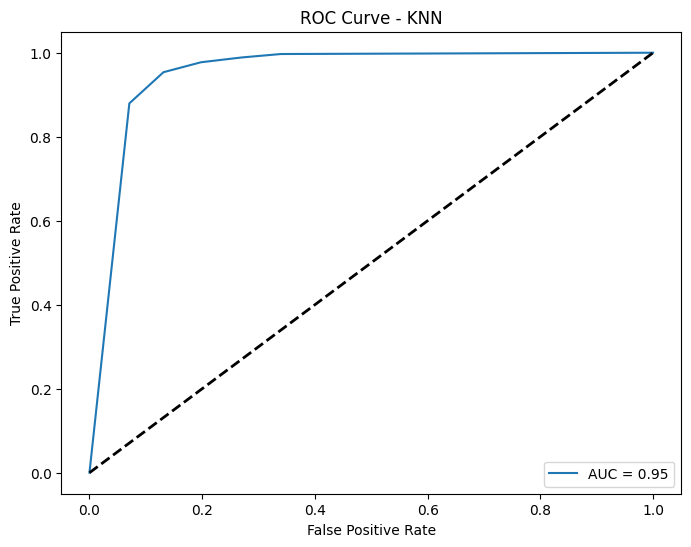

In [35]:
from sklearn.metrics import roc_curve, auc

# For KNN, predict_proba works too
y_proba = model.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_over, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.show()


#### Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_selected, y_train_over)
prediction7 = model.predict(X_test_selected)

print('The accuracy of the Random Forests is', metrics.accuracy_score(y_test_over, prediction7))


The accuracy of the Random Forests is 0.9434447300771208


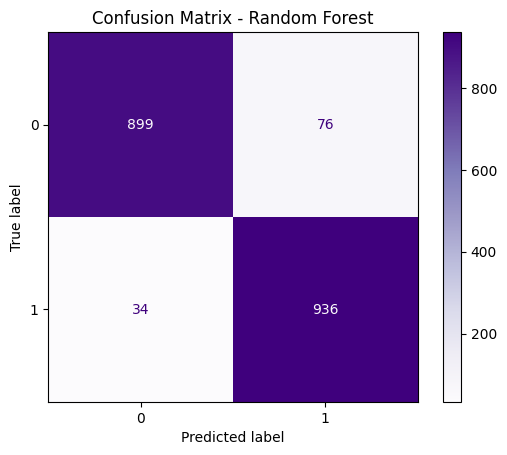

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test_over, prediction7)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Purples')
plt.title('Confusion Matrix - Random Forest')
plt.show()


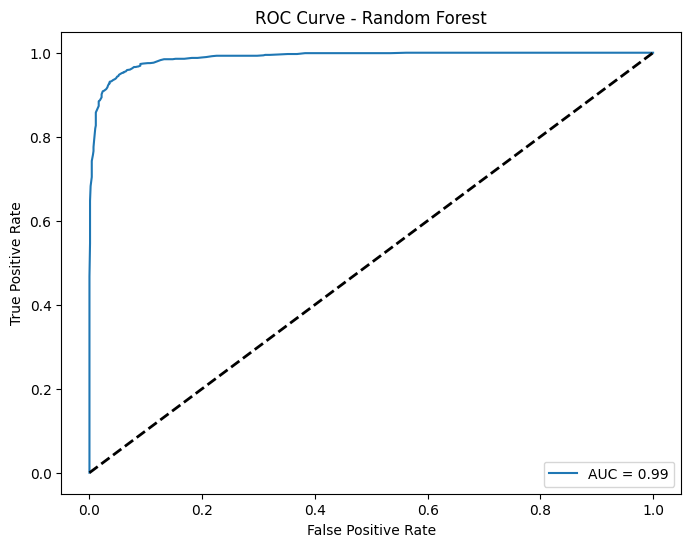

In [38]:
from sklearn.metrics import roc_curve, auc

y_proba = model.predict_proba(X_test_selected)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_over, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


### 4.2) Test Options and Evaluation Metric
Define the evaluation metric for the model.

Logistic Regression Accuracy: 0.8062
Decision Tree Accuracy: 0.8159
KNN Accuracy: 0.8895
Random Forest Accuracy: 0.9465


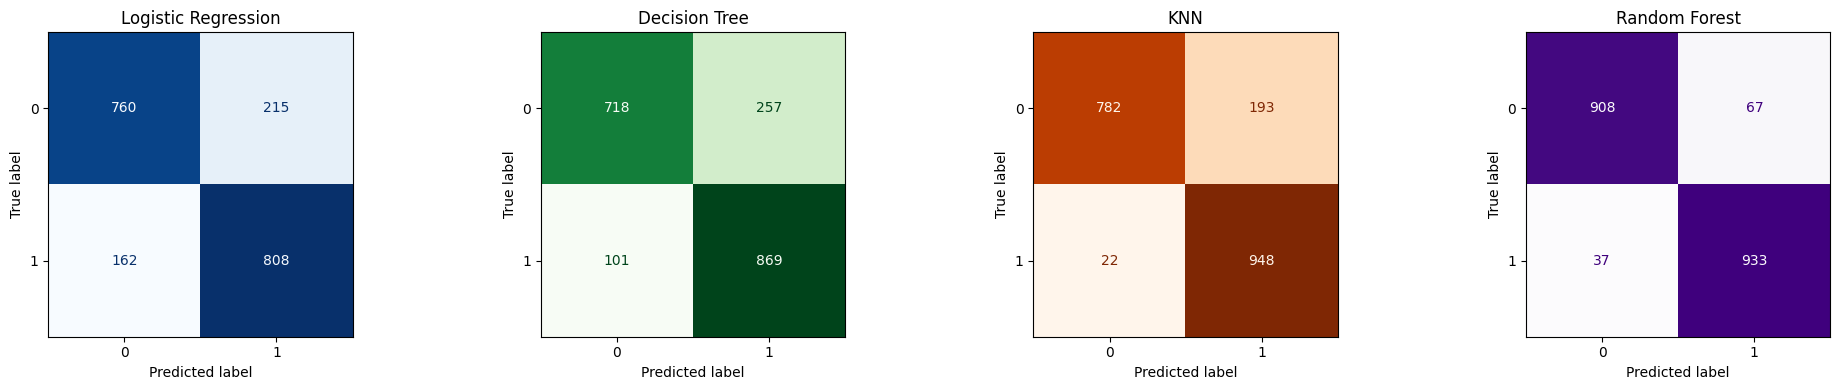

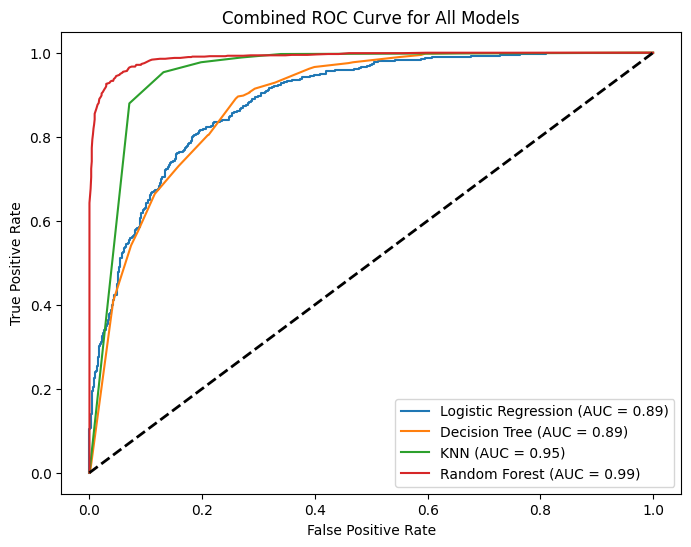

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
}

predictions = {}
probabilities = {}

for name, model in models.items():
    model.fit(X_train_selected, y_train_over)
    preds = model.predict(X_test_selected)
    predictions[name] = preds

    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test_selected)[:, 1]
        probabilities[name] = proba

    print(f"{name} Accuracy: {accuracy_score(y_test_over, preds):.4f}")

fig, axes = plt.subplots(1, len(models), figsize=(20, 4))

cmaps = ['Blues', 'Greens', 'Oranges', 'Purples']

for ax, (name, preds), cmap in zip(axes, predictions.items(), cmaps):
    cm = confusion_matrix(y_test_over, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap=cmap, colorbar=False)
    ax.set_title(f"{name}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))

for name, proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test_over, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Combined ROC Curve for All Models')
plt.legend(loc='lower right')
plt.show()

## <b> <font color=green> Performance Tuning & Optimization </font> </b>

### 4.1) Algorithm Tuning
Optimize hyperparameters for better performance.

Fitting 5 folds for each of 162 candidates, totalling 810 fits
 Best Random Forest Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
 Tuned Random Forest Accuracy: 0.9444730077120823


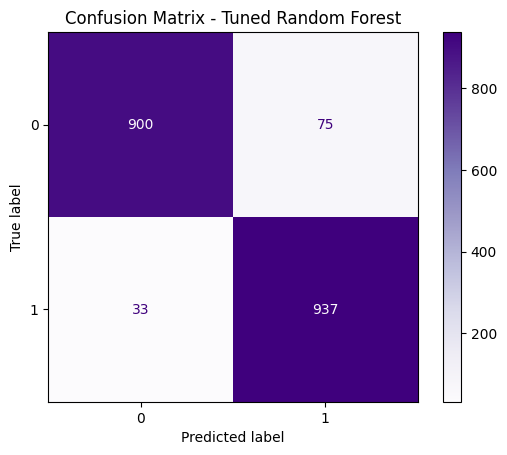

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_selected, y_train_over)

print(" Best Random Forest Hyperparameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
rf_tuned_preds = best_rf.predict(X_test_selected)
print(" Tuned Random Forest Accuracy:", accuracy_score(y_test_over, rf_tuned_preds))

cm = confusion_matrix(y_test_over, rf_tuned_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.title('Confusion Matrix - Tuned Random Forest')
plt.show()


### 4.2) Ensembles
Combine multiple models to improve accuracy.

In [41]:
from sklearn.ensemble import VotingClassifier


log_clf = LogisticRegression()
dt_clf = DecisionTreeClassifier(max_depth=5)
rf_clf = RandomForestClassifier(n_estimators=100)
knn_clf = KNeighborsClassifier()

ensemble = VotingClassifier(
    estimators=[
        ('Logistic', log_clf),
        ('DecisionTree', dt_clf),
        ('RandomForest', rf_clf),
        ('KNN', knn_clf)
    ],
    voting='soft'
)

ensemble.fit(X_train_selected, y_train_over)

ensemble_pred = ensemble.predict(X_test_selected)

from sklearn import metrics
acc = metrics.accuracy_score(y_test_over, ensemble_pred)

prec = metrics.precision_score(y_test_over, ensemble_pred)

rec = metrics.recall_score(y_test_over, ensemble_pred)

f1 = metrics.f1_score(y_test_over, ensemble_pred)

print(f"Soft-Voting Ensemble Evaluation:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1 Score  : {f1:.4f}")

Soft-Voting Ensemble Evaluation:
Accuracy  : 0.9028
Precision : 0.8599
Recall    : 0.9619
F1 Score  : 0.9080


In [42]:
models = {
    "Logistic Regression": prediction3,
    "Decision Tree": prediction4,
    "KNN": prediction5,
    "Random Forest": prediction7,
    "Ensemble": ensemble_pred,
    "Tuned Random Forest": rf_tuned_preds 
}


results = []

for name, preds in models.items():
    acc = accuracy_score(y_test_over, preds) * 100
    cm = confusion_matrix(y_test_over, preds)
    tp = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tn = cm[1][1] 
    results.append([name, acc, tp,fp,fn,tn])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy (%)', 'True Positive (TP)','False Positive (FP)','False Negatives (FN)','true Negatives (TN)'])
results_df.set_index('Model', inplace=True)
styled = results_df.style\
    .background_gradient(cmap='viridis')\
    .highlight_min(subset=['False Negatives (FN)'], color='red')\
    .format({'Accuracy (%)': "{:.1f}%"})\
    .set_table_styles([
        {'selector': 'thead th', 'props': [('background-color', '#333'), ('color', 'white')]},
        {'selector': 'tbody td', 'props': [('background-color', '#111'), ('color', 'white')]}
    ])

styled



,Accuracy (%),True Positive (TP),False Positive (FP),False Negatives (FN),true Negatives (TN)
Model,,,,,
Logistic Regression,80.6%,760,215,162,808
Decision Tree,91.0%,864,111,65,905
KNN,88.9%,782,193,22,948
Random Forest,94.3%,899,76,34,936
Ensemble,90.3%,823,152,37,933
Tuned Random Forest,94.4%,900,75,33,937
